In [1]:
import kagglehub
!pip install mplcyberpunk

In [2]:
import kagglehub
import os
import polars as pl
import numpy as np

import tensorflow as tf
from keras import layers, Model, optimizers, losses, metrics, callbacks
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from keras import layers, Model, optimizers, losses, metrics, callbacks
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

import warnings
warnings.filterwarnings('ignore')

plt.style.use('cyberpunk')

2025-08-11 02:36:09.412462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754879769.696685      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754879769.783573      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_df = pl.read_csv('/kaggle/input/dna-sequence-prediction/train.csv')
valid_df = pl.read_csv('/kaggle/input/dna-sequence-prediction/validation.csv')
test_df = pl.read_csv('/kaggle/input/dna-sequence-prediction/test.csv')

In [4]:
vals_to_take = train_df.filter(pl.col('GeneType') == "scRNA")[0]
valid_df = pl.concat([valid_df, vals_to_take])
train_df = train_df.filter(pl.col("") != 359)

In [5]:
train_df.null_count(), valid_df.null_count(), test_df.null_count()

(shape: (1, 7)
 ┌─────┬────────────┬────────┬─────────────┬──────────┬─────────────────┬────────────────────┐
 │     ┆ NCBIGeneID ┆ Symbol ┆ Description ┆ GeneType ┆ GeneGroupMethod ┆ NucleotideSequence │
 │ --- ┆ ---        ┆ ---    ┆ ---         ┆ ---      ┆ ---             ┆ ---                │
 │ u32 ┆ u32        ┆ u32    ┆ u32         ┆ u32      ┆ u32             ┆ u32                │
 ╞═════╪════════════╪════════╪═════════════╪══════════╪═════════════════╪════════════════════╡
 │ 0   ┆ 0          ┆ 0      ┆ 0           ┆ 0        ┆ 0               ┆ 0                  │
 └─────┴────────────┴────────┴─────────────┴──────────┴─────────────────┴────────────────────┘,
 shape: (1, 7)
 ┌─────┬────────────┬────────┬─────────────┬──────────┬─────────────────┬────────────────────┐
 │     ┆ NCBIGeneID ┆ Symbol ┆ Description ┆ GeneType ┆ GeneGroupMethod ┆ NucleotideSequence │
 │ --- ┆ ---        ┆ ---    ┆ ---         ┆ ---      ┆ ---             ┆ ---                │
 │ u32 ┆ u32       

In [6]:
def format_df(df : pl.DataFrame):
    concat_text = df.with_columns(
        pl.concat_str([
            pl.col('Symbol'),
            pl.col('Description'),
            pl.col('GeneGroupMethod')
        ], separator=" ").alias('Features')
    )

    df = concat_text.select(
        pl.col('Features'),
        pl.col('GeneType')
    )

    return df

train_df = format_df(train_df)
valid_df = format_df(valid_df)
test_df = format_df(test_df)

In [7]:
sk_encoder = OneHotEncoder(sparse_output=False)
sk_vectorizer = TfidfVectorizer()

def create_sklearn_ds(df, encoder, vectorizer, train):
    if train:
        x = vectorizer.fit_transform(df.select('Features').to_series())
        y = encoder.fit_transform(df.select('GeneType'))
    else:
        x = vectorizer.transform(df.select('Features').to_series())
        y = encoder.transform(df.select('GeneType'))
    y = np.argmax(y, axis=1)
    return x, y

sk_x_train, sk_y_train = create_sklearn_ds(train_df, sk_encoder, sk_vectorizer, train=True)
sk_x_valid, sk_y_valid = create_sklearn_ds(valid_df, sk_encoder, sk_vectorizer, train=False)
sk_x_test, sk_y_test = create_sklearn_ds(test_df, sk_encoder, sk_vectorizer, train=False)

In [8]:
def create_keras_ds(df):
    x = df.select('Features').to_numpy()
    y = df.select('GeneType').to_dummies().to_numpy()
    return tf.constant(x, dtype=tf.string), y

k_x_train, k_y_train = create_keras_ds(train_df)
k_x_valid, k_y_valid = create_keras_ds(valid_df)
k_x_test, k_y_test = create_keras_ds(test_df)

2025-08-11 02:36:35.650307: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
sk_models = {
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier' : GradientBoostingClassifier(),
    'LogisticRegression' : LogisticRegression(),
    'LinearSVC' : LinearSVC(),
    'KNeighborsClassifier' : KNeighborsClassifier()
}

In [10]:
preds = {}
accuracies = {}

In [11]:
for sk_model in sk_models:
    current_model = sk_models[sk_model]
    current_model.fit(sk_x_train, sk_y_train)
    current_pred = current_model.predict(sk_x_test)
    preds[sk_model] = current_pred

In [12]:
vectorizer = layers.TextVectorization(
    max_tokens=10000,
    output_mode='tf_idf',
)
vectorizer.adapt(k_x_train)

inputs = layers.Input(shape=(1,), dtype=tf.string)
vectorize_layer = vectorizer(inputs)
x = layers.Dense(units=64, activation='relu')(vectorize_layer)
x = layers.Dense(units=64, activation='relu')(x)
x = layers.Dense(units=128, activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)
outputs = layers.Dense(units=10, activation='softmax')(x)

keras_model = Model(inputs, outputs)
keras_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 10000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 653,834 (2.49 MB)

 Trainable params: 653,834 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
keras_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)

early_stopping = callbacks.EarlyStopping(
    patience=20
)

lr_plataeu = callbacks.ReduceLROnPlateau(
    patience=15
)

keras_history = keras_model.fit(
    x=k_x_train,
    y=k_y_train,
    batch_size=32,
    epochs=30,
    validation_data=(k_x_valid, k_y_valid),
    callbacks=[early_stopping, lr_plataeu]
)

Epoch 1/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - categorical_accuracy: 0.8291 - loss: 0.5917 - val_categorical_accuracy: 0.9779 - val_loss: 0.0562 - learning_rate: 0.0010
Epoch 2/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.9756 - loss: 0.0616 - val_categorical_accuracy: 0.9825 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 3/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.9815 - loss: 0.0440 - val_categorical_accuracy: 0.9823 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 4/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.9817 - loss: 0.0418 - val_categorical_accuracy: 0.9836 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 5/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.9853 - loss: 0.0337 - val_categorical_accuracy: 0.9845 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 6/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.9850 - loss: 0.0346 - val_categoric

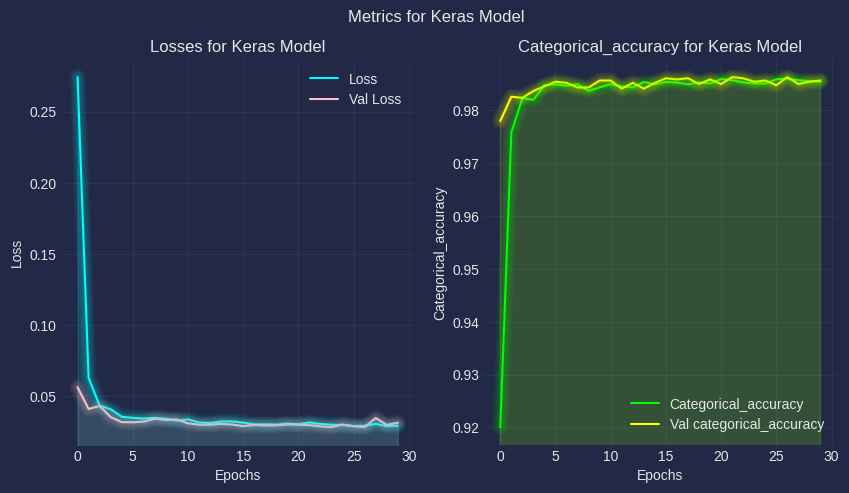

In [14]:
def plot_keras_metrics(hist, metric, colors):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(f'Metrics for Keras Model')
    ax[0].set_title(f'Losses for Keras Model')
    ax[0].set_ylabel(f'Loss')
    ax[0].plot(hist['loss'], color=colors[0], label='Loss')
    ax[0].plot(hist['val_loss'], color=colors[1], label='Val Loss')
    
    ax[1].set_title(f'{metric.capitalize()} for Keras Model')
    ax[1].set_ylabel(f'{metric.capitalize()}')
    ax[1].plot(hist[metric], color=colors[2], label=metric.capitalize())
    ax[1].plot(hist['val_'+metric], color=colors[3], label='Val ' + metric)

    for i in range(2):
        axes = ax[i]
        axes.set_xlabel('Epochs')
        axes.legend()
        mplcyberpunk.make_lines_glow(ax=axes)
        mplcyberpunk.add_underglow(ax=axes)

plot_keras_metrics(
    hist=keras_history.history,
    metric='categorical_accuracy',
    colors=['cyan', 'pink', 'lime', 'yellow']
)

In [15]:
keras_pred = keras_model.predict(k_x_test)
keras_pred = tf.argmax(keras_pred, axis=1)
k_y_test = tf.argmax(k_y_test, axis=1)

preds.update(Keras=keras_pred)
target_names = train_df.select('GeneType').unique().to_numpy().squeeze().tolist()

for model in preds:
    model_pred = preds[model]
    
    if model == 'Keras':
        y_test = k_y_test
    else:
        y_test = sk_y_test

    accuracies[model] = accuracy_score(y_test, model_pred)
    print(f'Classification Report for {model}:\n{classification_report(y_test, model_pred, target_names=target_names)}')

261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Classification Report for RandomForestClassifier:
                   precision    recall  f1-score   support

             rRNA       1.00      1.00      1.00      2651
            snRNA       0.99      0.98      0.99       133
           PSEUDO       0.92      0.91      0.92       184
             tRNA       0.99      0.98      0.99      3800
            scRNA       0.99      1.00      1.00       894
            OTHER       0.74      1.00      0.85        72
BIOLOGICAL_REGION       0.00      0.00      0.00         1
   PROTEIN_CODING       0.79      0.79      0.79        38
            ncRNA       0.97      1.00      0.99       405
           snoRNA       0.99      1.00      1.00       148

         accuracy                           0.99      8326
        macro avg       0.84      0.87      0.85      8326
     weighted avg       0.99      0.99      0.99      8326

Classification Report for GradientBoostingClassifier:
                   precisi

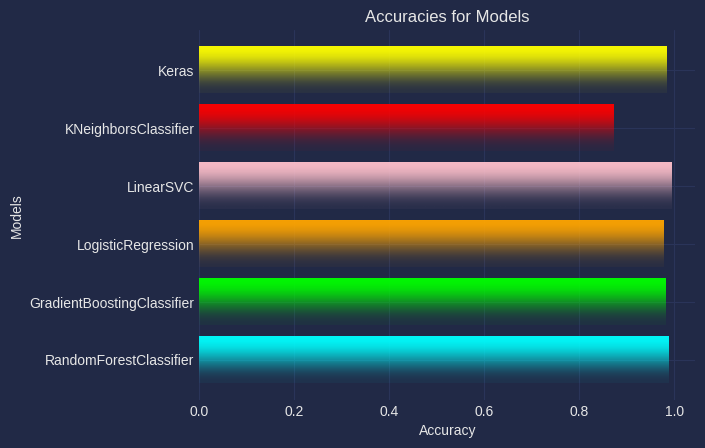

In [16]:
plt.title('Accuracies for Models')
plt.xlabel('Accuracy')
plt.ylabel('Models')
bars = plt.barh(list(accuracies.keys()), list(accuracies.values()), color=['cyan', 'lime', 'orange', 'pink', 'red', 'yellow'])
mplcyberpunk.add_bar_gradient(bars)

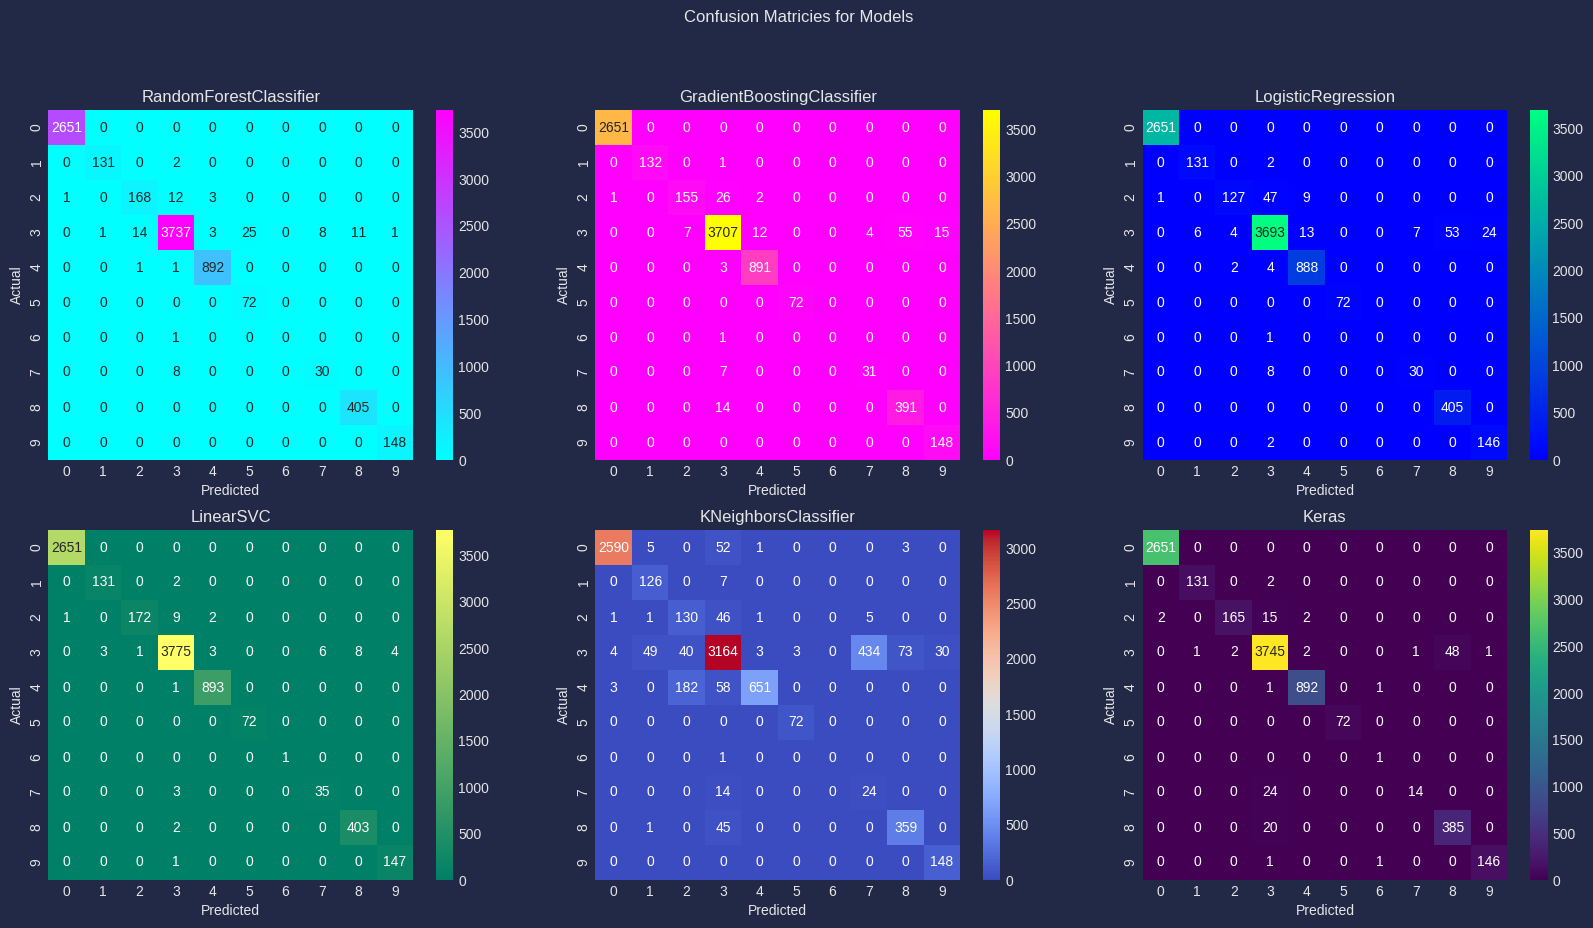

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.suptitle("Confusion Matricies for Models")
cmaps = ['cool', 'spring', 'winter', 'summer', 'coolwarm', 'viridis']

for idx, model in enumerate(preds):
    axes = ax[idx // 3, idx % 3]
    axes.set_title(model)
    model_pred = preds[model]

    if model == 'Keras':
        y_test = k_y_test
    else:
        y_test = sk_y_test
    
    cm = confusion_matrix(y_test, model_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmaps[idx], ax=axes)
    axes.set_ylabel('Actual')
    axes.set_xlabel('Predicted')